<a href="https://colab.research.google.com/github/Nikita-devel/DS_Hw5/blob/main/DS_Hm5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, accuracy_score

In [11]:
from pathlib import Path

DATASET_KEYS = ("f0s0", "f0s1", "f1s0", "f1s1")
SAVED_DATAFRAME_BASE = Path("/content/")
URL = "https://drive.usercontent.google.com/download?id=1nzrtQpfaHL0OgJ_eXzA7VuEj7XotrSWO&export=download&authuser=0"
OUTPUT = Path("/content/homework")
CSV_DATA_PATH  = Path("/content/data")

In [12]:
if not OUTPUT.is_file():
  !wget -O $OUTPUT $URL

if OUTPUT.is_file() and not CSV_DATA_PATH.is_dir():
  !unzip -q -o $OUTPUT
  #!rm $OUTPUT



--2024-02-19 21:16:15--  https://drive.usercontent.google.com/download?id=1nzrtQpfaHL0OgJ_eXzA7VuEj7XotrSWO
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.139.132, 2607:f8b0:400c:c05::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.139.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4211746 (4.0M) [application/octet-stream]
Saving to: ‘/content/homework’

/content/homework   100%[===================>]   4.02M  25.1MB/s    in 0.2s    

2024-02-19 21:16:45 (25.1 MB/s) - ‘/content/homework’ saved [4211746/4211746]



In [13]:
if CSV_DATA_PATH.is_dir():
  class_path = list(CSV_DATA_PATH.iterdir())
  class_list = list(d.name for d in class_path)
  print(class_list)

['stairs', 'running', 'idle', 'walking']


In [14]:
def gen_saved_name(key):
  return SAVED_DATAFRAME_BASE.joinpath(f"data-{key}.father")
df_set = {}
X_set = {}
y_set = {}
reports = {}

skip_load = False

for key in DATASET_KEYS:
  filename = gen_saved_name(key)
  if not skip_load and filename.is_file():
    df_set[key] = pd.read_feather(filename)
    X_set[key] = df_set[key].iloc[:,:-1]
    y_set[key] = df_set[key].iloc[:,-1]
    print(f"DATASET {key}. Loaded. shape: {df_set[key].shape}")
  else:
    df_set[key] = pd.DataFrame()

In [16]:
def save_dataset(key,df):
  filename = gen_saved_name(key)
  if not df.empty and not filename.is_file():
    df.to_feather(filename)


def flatten_frame(frame):
    columns=[f"{col}_{i}" for i in range(frame.shape[0]) for col in frame.columns]
    return pd.DataFrame(frame.values.reshape(1, -1), columns=columns)


def add_stat_feature_frame(frame, rows):
  features = []
  for col_id in range(0,3):
    col = frame.iloc[:,col_id]
    features.append(pd.DataFrame([col.mean()] * rows,columns=[f'{col.name}_mean']))
    features.append(pd.DataFrame([col.max()] * rows,columns=[f'{col.name}_max']))
    features.append(pd.DataFrame([col.min()] * rows,columns=[f'{col.name}_min']))
    features.append(pd.DataFrame([col.quantile(0.75)-col.quantile(0.25)] * rows,columns=[f'{col.name}_interquartile_range']))
    features.append(pd.DataFrame([col.idxmin()] * rows,columns=[f'{col.name}_index_of_minimum_value']))
    features.append(pd.DataFrame([np.mean(np.abs(col - col.mean()))] * rows,columns=[f'{col.name}_mean_of_absolute_deviation']))
    features.append(pd.DataFrame([col.median()] * rows,columns=[f'{col.name}_median']))
    # features.append(pd.DataFrame([df.skew(axis=0).iloc[:,col_id]] * rows,columns=[f'{col.name}_skewness']))
    features.append(pd.DataFrame([col.std()] * rows,columns=[f'{col.name}_standard_deviation']))
    features.append(pd.DataFrame([np.sqrt(np.mean(col)**2)] * rows,columns=[f'{col.name}_root_mean_square_error']))

  result = pd.concat(features, axis=1)
  # print(f"New stats features: {result.columns}")
  return result


def prepare_dataset(class_path: list[Path], flatten = True, stat_feture = True, limit_frames = None):
  dfws = []
  for class_id, work_class_path in enumerate(class_path):
    list_files = list(sorted(work_class_path.glob('*.csv'), key=lambda path: int(path.stem.rsplit("-", 1)[1])))
    print(f"Importing class '{work_class_path.name:7}' : {class_id}. Frames: {len(list_files)}")
    for i, filename in enumerate(list_files):
      # READ FRAME CSV FILE
      df_w: pd.DataFrame = pd.read_csv(filename)
      addon_features = [df_w]
      if flatten:
        addon_features = [flatten_frame(df_w)]
      if stat_feture:
        addon_features.append(add_stat_feature_frame(df_w,addon_features[0].shape[0]))
      df_w = pd.concat(addon_features, axis=1)
      df_w['class'] = class_id
      dfws.append(df_w)
      if limit_frames and (i > limit_frames):
        break
  df = pd.concat(dfws, axis=0, ignore_index=True)
  # print(df.info())
  print(df.shape)
  return df

In [17]:
limit_frames = None
for f in range(2):
  for s in range(2):
    key_set = f"f{f}s{s}"
    print(f"\nDATASET {key_set}. Where flatten={bool(f)}, stat_feture={bool(s)}")
    if df_set.get(key_set) is not None and (not df_set[key_set].empty):
      print("Alredy loaded, skipped")
      continue
    df_set[key_set] = prepare_dataset(class_path, flatten = f, stat_feture = s, limit_frames = limit_frames)
    save_dataset(key_set, df_set[key_set])
    # print(df_set[key_set].sample(4))
    X_set[key_set] = df_set[key_set].iloc[:,:-1]
    y_set[key_set] = df_set[key_set].iloc[:,-1]


DATASET f0s0. Where flatten=False, stat_feture=False
Importing class 'stairs ' : 0. Frames: 165
Importing class 'running' : 1. Frames: 3408
Importing class 'idle   ' : 2. Frames: 1039
Importing class 'walking' : 3. Frames: 1850
(193860, 4)

DATASET f0s1. Where flatten=False, stat_feture=True
Importing class 'stairs ' : 0. Frames: 165
Importing class 'running' : 1. Frames: 3408
Importing class 'idle   ' : 2. Frames: 1039
Importing class 'walking' : 3. Frames: 1850
(193860, 31)

DATASET f1s0. Where flatten=True, stat_feture=False
Importing class 'stairs ' : 0. Frames: 165
Importing class 'running' : 1. Frames: 3408
Importing class 'idle   ' : 2. Frames: 1039
Importing class 'walking' : 3. Frames: 1850
(6462, 91)

DATASET f1s1. Where flatten=True, stat_feture=True
Importing class 'stairs ' : 0. Frames: 165
Importing class 'running' : 1. Frames: 3408
Importing class 'idle   ' : 2. Frames: 1039
Importing class 'walking' : 3. Frames: 1850
(6462, 118)


In [18]:
key_set = list(df_set.keys())[0]
for x in df_set[key_set]['class'].unique():
  count = df_set[key_set]['class'][df_set[key_set]['class'] == x].count()
  prop = count / df_set[key_set].shape[0]
  print(f"class: {x}, rows: {count:7}, {class_list[x]:7}, prop: {prop:.4}" )

class: 0, rows:    4950, stairs , prop: 0.02553
class: 1, rows:  102240, running, prop: 0.5274
class: 2, rows:   31170, idle   , prop: 0.1608
class: 3, rows:   55500, walking, prop: 0.2863


In [19]:
models = {"SVC": lambda: SVC(),
          "SVC_Linear": lambda: SVC(kernel="linear"),
          "RandomForestClassifier": lambda: RandomForestClassifier()}
reports = {}
skip_models = {
    "SVC_Linear": ["f0s0"]
}


In [20]:
SEED = 42
print("Models fit and prepare report")
for key in X_set.keys():
  print("-"*80)
  print(f"DATASET {key}. shape: {df_set[key].shape}")
  X = X_set[key]
  y = y_set[key]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED, stratify=y)
  if reports.get(key) is None:
    reports[key] = {}
  for model, classification in models.items():
    print(f"\n- classification: {model}")
    if reports[key].get(model):
      print("   alredy fit, skipped")
      continue
    if key in skip_models.get(model,[]):
      print("   skip this model")
      continue
    clf = classification()
    %time clf.fit(X_train, y_train)
    %time y_test_predict = clf.predict(X_test)
    reports[key][model] = classification_report(y_test, y_test_predict, digits=4, target_names=class_list)


Models fit and prepare report
--------------------------------------------------------------------------------
DATASET f0s0. shape: (193860, 4)

- classification: SVC
CPU times: user 4min 28s, sys: 657 ms, total: 4min 29s
Wall time: 4min 59s
CPU times: user 1min 48s, sys: 80.9 ms, total: 1min 48s
Wall time: 1min 49s

- classification: SVC_Linear
   skip this model

- classification: RandomForestClassifier
CPU times: user 13.5 s, sys: 20.9 ms, total: 13.5 s
Wall time: 13.5 s
CPU times: user 954 ms, sys: 0 ns, total: 954 ms
Wall time: 957 ms
--------------------------------------------------------------------------------
DATASET f0s1. shape: (193860, 31)

- classification: SVC
CPU times: user 27.5 s, sys: 181 ms, total: 27.7 s
Wall time: 27.9 s
CPU times: user 18.6 s, sys: 16.9 ms, total: 18.6 s
Wall time: 18.8 s

- classification: SVC_Linear
CPU times: user 1min 39s, sys: 255 ms, total: 1min 40s
Wall time: 1min 40s
CPU times: user 6.13 s, sys: 5.02 ms, total: 6.13 s
Wall time: 6.12 s

-

In [21]:
print(f"{limit_frames=}")
for dset in reports.keys():
  for model in reports[dset].keys():
    print("-"*80)
    print(f"Data set: {dset}, shape: {df_set[dset].shape}, model: {model}")
    print(reports[dset][model])

limit_frames=None
--------------------------------------------------------------------------------
Data set: f0s0, shape: (193860, 4), model: SVC
              precision    recall  f1-score   support

      stairs     1.0000    0.0027    0.0054      1485
     running     0.9327    0.8986    0.9153     30672
        idle     0.9549    0.9843    0.9694      9351
     walking     0.7944    0.9047    0.8460     16650

    accuracy                         0.8913     58158
   macro avg     0.9205    0.6976    0.6840     58158
weighted avg     0.8984    0.8913    0.8809     58158

--------------------------------------------------------------------------------
Data set: f0s0, shape: (193860, 4), model: RandomForestClassifier
              precision    recall  f1-score   support

      stairs     1.0000    0.9953    0.9976      1485
     running     0.9996    1.0000    0.9998     30672
        idle     0.9997    0.9995    0.9996      9351
     walking     0.9998    0.9996    0.9997     16650



# Results Summary

## Datasets Overview
Different datasets were created from CSV source files downloaded from various folders, each named according to the related activity.

- **Dataset f0s0:** Contains data with 4 features.
- **Dataset f0s1:** Contains data with 31 features.
- **Dataset f1s0:** Contains data with 91 features.
- **Dataset f1s1:** Contains data with 118 features.

In the 'f0s0' dataset, the SVC-Linear model was skipped during log-time operation, potentially exceeding one hour.

## Models Used
The models used for analysis included:
- Support Vector Classifier (SVC)
- Support Vector Classifier with Linear Kernel (SVC-Linear)
- Random Forest Classifier

## Model Performance

- For the dataset with 4 features (f0s0), the **RandomForestClassifier** performs better.
- For the dataset with 31 features (f0s1), the **RandomForestClassifier** performs better.
- For the dataset with 91 features (f1s0), the **RandomForestClassifier** performs better.
- For the dataset with 118 features (f1s1), the **RandomForestClassifier** performs better.

The dataset 'f0s1' achieved a perfect accuracy of **1.0000**, making it the highest among the provided datasets.

## Additional Information
- The dataset 'f0s1' has not been flattened, and statistical features have been added.
- The winner is dataset 'f0s1' with 31 features when using the **RandomForestClassifier** model.


In [22]:
rows = 10
df_one = df_set['f0s0'].iloc[:rows,:3]
df_one_class = df_set['f0s0'].iloc[:rows,3]
df_one_class

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: class, dtype: int64

In [23]:
df_one_stat = add_stat_feature_frame(df_one,df_one.shape[0])
df_one_stat

,accelerometer_X_mean,accelerometer_X_max,accelerometer_X_min,accelerometer_X_interquartile_range,accelerometer_X_index_of_minimum_value,accelerometer_X_mean_of_absolute_deviation,accelerometer_X_median,accelerometer_X_standard_deviation,accelerometer_X_root_mean_square_error,accelerometer_Y_mean,...,accelerometer_Y_root_mean_square_error,accelerometer_Z_mean,accelerometer_Z_max,accelerometer_Z_min,accelerometer_Z_interquartile_range,accelerometer_Z_index_of_minimum_value,accelerometer_Z_mean_of_absolute_deviation,accelerometer_Z_median,accelerometer_Z_standard_deviation,accelerometer_Z_root_mean_square_error
0,3.635835,7.891289,-2.868254,3.416526,6,2.629025,4.548984,3.395985,3.635835,-3.886747,...,3.886747,-0.209253,3.936068,-3.342306,1.824381,1,1.705821,0.019154,2.321275,0.209253
1,3.635835,7.891289,-2.868254,3.416526,6,2.629025,4.548984,3.395985,3.635835,-3.886747,...,3.886747,-0.209253,3.936068,-3.342306,1.824381,1,1.705821,0.019154,2.321275,0.209253
2,3.635835,7.891289,-2.868254,3.416526,6,2.629025,4.548984,3.395985,3.635835,-3.886747,...,3.886747,-0.209253,3.936068,-3.342306,1.824381,1,1.705821,0.019154,2.321275,0.209253
3,3.635835,7.891289,-2.868254,3.416526,6,2.629025,4.548984,3.395985,3.635835,-3.886747,...,3.886747,-0.209253,3.936068,-3.342306,1.824381,1,1.705821,0.019154,2.321275,0.209253
4,3.635835,7.891289,-2.868254,3.416526,6,2.629025,4.548984,3.395985,3.635835,-3.886747,...,3.886747,-0.209253,3.936068,-3.342306,1.824381,1,1.705821,0.019154,2.321275,0.209253
5,3.635835,7.891289,-2.868254,3.416526,6,2.629025,4.548984,3.395985,3.635835,-3.886747,...,3.886747,-0.209253,3.936068,-3.342306,1.824381,1,1.705821,0.019154,2.321275,0.209253
6,3.635835,7.891289,-2.868254,3.416526,6,2.629025,4.548984,3.395985,3.635835,-3.886747,...,3.886747,-0.209253,3.936068,-3.342306,1.824381,1,1.705821,0.019154,2.321275,0.209253
7,3.635835,7.891289,-2.868254,3.416526,6,2.629025,4.548984,3.395985,3.635835,-3.886747,...,3.886747,-0.209253,3.936068,-3.342306,1.824381,1,1.705821,0.019154,2.321275,0.209253
8,3.635835,7.891289,-2.868254,3.416526,6,2.629025,4.548984,3.395985,3.635835,-3.886747,...,3.886747,-0.209253,3.936068,-3.342306,1.824381,1,1.705821,0.019154,2.321275,0.209253
9,3.635835,7.891289,-2.868254,3.416526,6,2.629025,4.548984,3.395985,3.635835,-3.886747,...,3.886747,-0.209253,3.936068,-3.342306,1.824381,1,1.705821,0.019154,2.321275,0.209253


In [24]:
X_test_one = pd.concat([df_one, df_one_stat], axis=1)
X_test_one.fillna(0, inplace=True)
X_test_one[:1]

,accelerometer_X,accelerometer_Y,accelerometer_Z,accelerometer_X_mean,accelerometer_X_max,accelerometer_X_min,accelerometer_X_interquartile_range,accelerometer_X_index_of_minimum_value,accelerometer_X_mean_of_absolute_deviation,accelerometer_X_median,...,accelerometer_Y_root_mean_square_error,accelerometer_Z_mean,accelerometer_Z_max,accelerometer_Z_min,accelerometer_Z_interquartile_range,accelerometer_Z_index_of_minimum_value,accelerometer_Z_mean_of_absolute_deviation,accelerometer_Z_median,accelerometer_Z_standard_deviation,accelerometer_Z_root_mean_square_error
0,6.727707,2.973599,3.936068,3.635835,7.891289,-2.868254,3.416526,6,2.629025,4.548984,...,3.886747,-0.209253,3.936068,-3.342306,1.824381,1,1.705821,0.019154,2.321275,0.209253


In [25]:
key = 'f0s1'
X = X_set[key]
y = y_set[key]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED, stratify=y)
# clf = SVC(kernel="linear")
clf = RandomForestClassifier()
%time clf.fit(X_train, y_train)

CPU times: user 16.2 s, sys: 43.7 ms, total: 16.2 s
Wall time: 16.3 s


RandomForestClassifier()

In [26]:
y_test_predict_one = clf.predict(X_test_one[:1])
y_test_predict_one

array([0])

In [28]:
key_set = list(df_set.keys())[0]
total = df_set[key_set].shape[0]
df_t = df_set[key_set]['class'].value_counts().to_dict()
for x in sorted(df_t.keys()):
  count = df_t[x]
  prop = count / total
  print(f"class: {x}, rows: {count:7}, {class_list[x]:7}, prop: {prop:.4}" )

class: 0, rows:    4950, stairs , prop: 0.02553
class: 1, rows:  102240, running, prop: 0.5274
class: 2, rows:   31170, idle   , prop: 0.1608
class: 3, rows:   55500, walking, prop: 0.2863


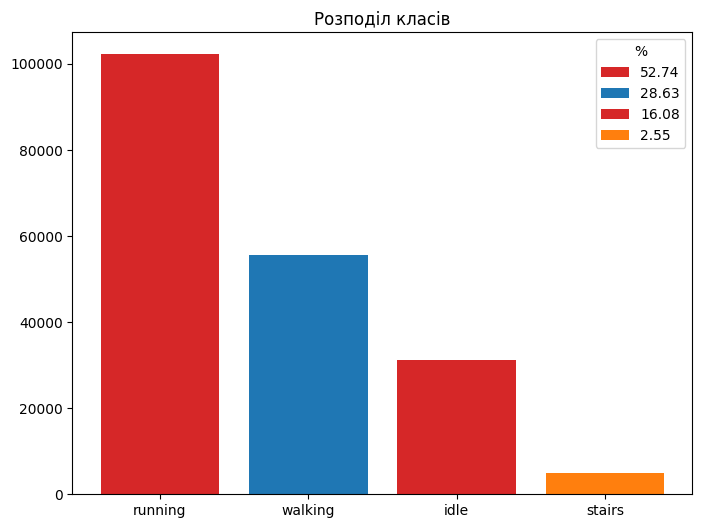

In [29]:
# Візуалізація розподілу класів
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
#sns.countplot(x='class', data=df_set[key_set])
bar_colors = ['tab:red', 'tab:blue', 'tab:red', 'tab:orange']
df_t = df_set[key_set]['class'].value_counts()
plt.bar(x=df_t.index.map(lambda x: class_list[x]), height=df_t, color=bar_colors, label=(df_t/total*100).round(2) )
plt.title('Розподіл класів')
plt.legend(title='%')
plt.show()

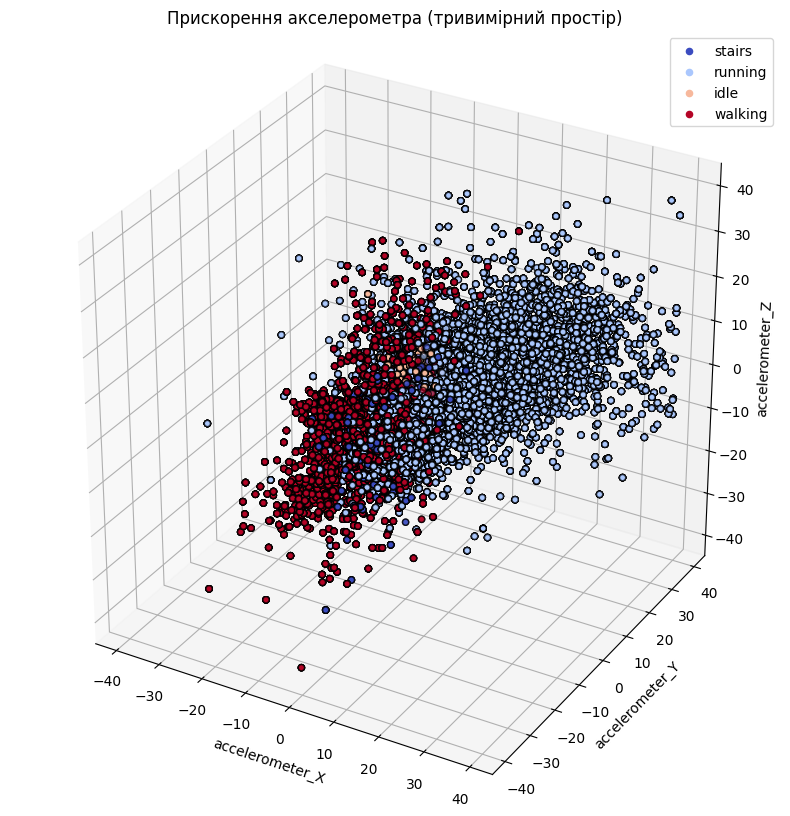

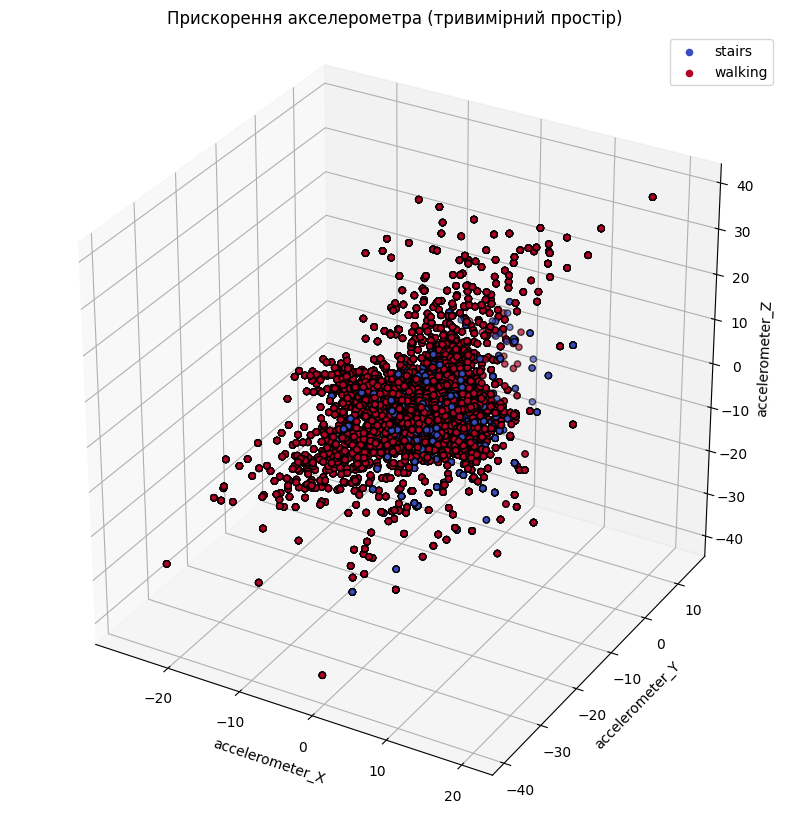

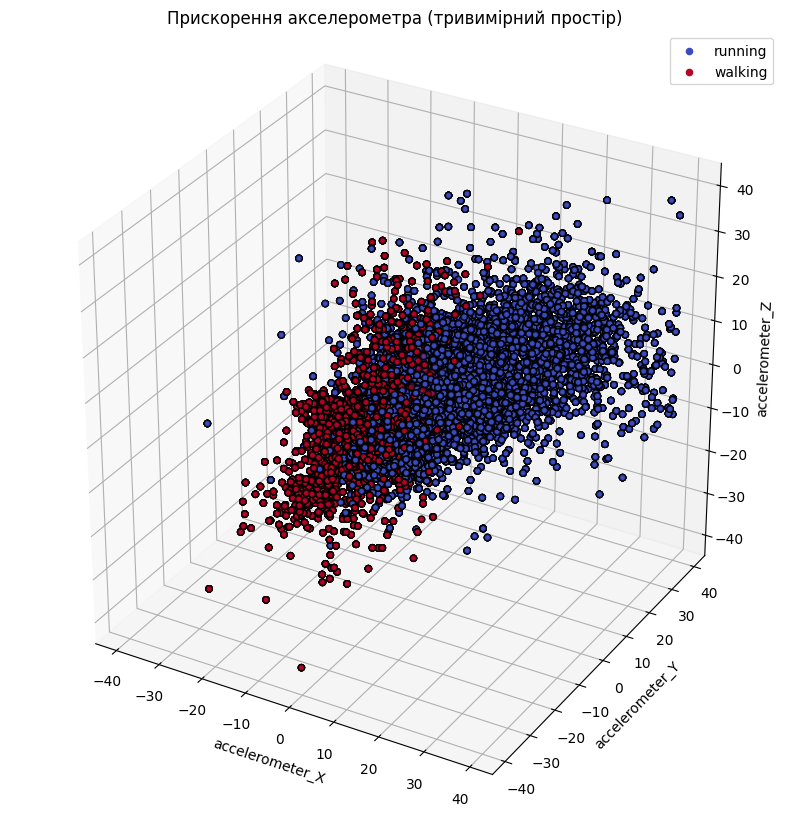

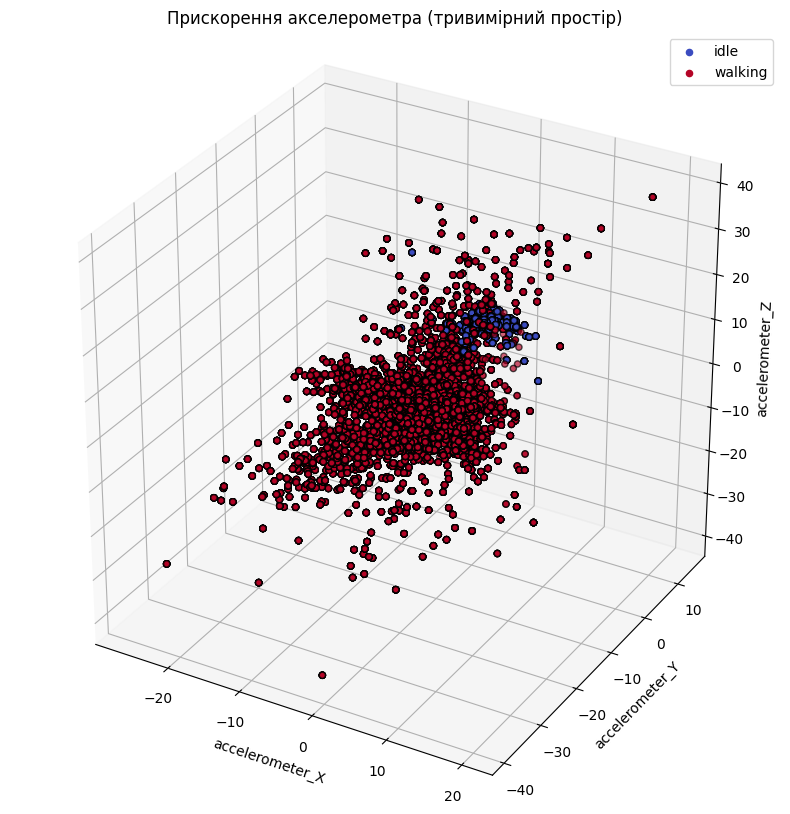

In [30]:
def plot_3d(df_t):
  xx = df_t.iloc[:,0]
  yy = df_t.iloc[:,1]
  zz = df_t.iloc[:,2]
  cc = df_t.iloc[:,3]
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(projection='3d')

  sc = ax.scatter(xx, yy, zz, c=cc, cmap='coolwarm', edgecolors='k')
  unique_categories = np.unique(cc)
  colors = plt.cm.coolwarm(np.linspace(0, 1, len(unique_categories)))
  #print(colors)
  for i,c in enumerate(unique_categories):
      ax.scatter([], [], [], color=colors[i], label=f'{class_list[c]}')
  ax.set_xlabel(df_set[key].columns[0])
  ax.set_ylabel(df_set[key].columns[1])
  ax.set_zlabel(df_set[key].columns[2])
  ax.set_title('Прискорення акселерометра (тривимірний простір)')
  ax.set_box_aspect([1, 1, 1])  # Set the aspect ratio to be 1:1:1
  ax.legend()
  plt.show()


key = "f0s0"
actions_1 = [0,3]
actions_2 = [1,3]
actions_3 = [2,3]
df_t = df_set[key]
plot_3d(df_t)
plot_3d(df_t[df_t["class"].isin(actions_1)])
plot_3d(df_t[df_t["class"].isin(actions_2)])
plot_3d(df_t[df_t["class"].isin(actions_3)])
del df_t